# 注意力打分函数

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

(1) torch.nn中包含的是封装好的类，继承自nn.Module，调用时先实例化，然后在__init__()中初始化，再在forward()中进行操作。

(2) torch.nn.functional中包含的是实现好的函数，直接通过接口调用。

In [2]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行softmax操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1: # 一维张量
            valid_lens = torch.repeat_interleave(valid_lens, shape[1]) # 将每个元素按照X的shape[1]进行重复
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0 
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4055, 0.5945, 0.0000, 0.0000],
         [0.5733, 0.4267, 0.0000, 0.0000]],

        [[0.2375, 0.4062, 0.3563, 0.0000],
         [0.4615, 0.3002, 0.2383, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.1933, 0.4053, 0.4013, 0.0000]],

        [[0.6781, 0.3219, 0.0000, 0.0000],
         [0.2742, 0.2367, 0.2200, 0.2692]]])

In [5]:
# 如果处于model.eval模式时，并不会使用Dropout。
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        #bias=False无需偏置
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout) # 正则化

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)  #(2, 10, 4)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

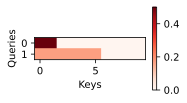

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [8]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

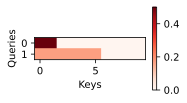

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')